# Resolução em energia

Neste experimento caracterizamos a resolução do espectrômetro gama.

## Dependência em energia

Por argumentos estatísticos, a largura das linhas $\Delta E$ deve obedecer

$$ \frac{\Delta E}{E} \propto \frac{\sqrt{E}}{E} $$

No caso de detectores de NaI(Tl) esta relação pode ser expressa como

$$ \left(\frac{\Delta E}{E}\right)^2 = \frac{m}{E} + b $$

para $m$ e $b$ constantes a serem determinadas.

Checamos aqui estas relações utilizando as linhas espectrais obtidas para amostras de ${}^{22}$Na, ${}^{133}$Ba, ${}^{109}$Cd, ${}^{57}$Co, ${}^{60}$Co, $^{137}$Cs, ${}^{54}$Mn e ${}^{232}$Th.

Primeiramente carregamos os centróides e fwhm registrados, em canais, pelo programa de aquisição nos arquivos com os espectros de cada amostra. Com a calibração efetuada, convertemos estes valores para keV e comparamos com valores padrão para as transições da amostra usada (obtidas do site http://www.nucleide.org/DDEP_WG/DDEPdata_by_A.htm), de forma a descartar picos espúrios eventualmente detectados. Finalmente plotamos $\log\left(\frac{\Delta E}{E}\right)$ vs. $\sqrt{E}$ e $\left(\frac{\Delta E}{E}\right)^2$ vs. $\frac{1}{E}$, e ajustamos retas a ambos os gráficos. Para o primeiro esperamos encontrar um coeficiente angular de $-0.5$.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import sys

sys.path.insert(0, "../")

from scipy.optimize import curve_fit
from scipy.signal import gaussian
from scipy.ndimage import filters

from common import *

%matplotlib inline

In [2]:
pars_calibracao = np.array([3.8215880409588541e-05, 0.031908378390707419, 6.140984458104163])
incertezas_calibracao = np.array([2.0005452742905427e-05, 0.013574765061956408, 2.0394318835612819])
data_dir = '../../dados/'
nomes_arquivos = ['na22_15032017_1622.tsv', 'ba133_15032017_1718.tsv', 'cd109_15032017_1653.tsv', 
                  'co57_15032017_1734.tsv', 'co60_15032017_1752.tsv', 'cs137_15032017_1705.tsv',
                  'mn54_15032017_1624.tsv', 'th232_15032017_1716.tsv']
arquivos = {
        nome.split('_')[0]: os.path.join(data_dir, nome) \
        for nome in nomes_arquivos
    }
amostra_desconhecida = os.path.join(data_dir, 'desconhecida_15032017_1800.tsv')

#lines = {amostra: load_lines(amostra) for amostra in arquivos.keys()}

In [3]:
delta_E = []
E = []
amostras = []
for amostra in arquivos.keys():
    fwhm, cent = load_peaks(arquivos[amostra], amostra, pars=pars_calibracao)
    delta_E.extend(list(fwhm))
    E.extend(list(cent))
    amostras.append(amostra)
delta_E = np.array(delta_E)    # valores da largura de todas as linhas encontradas
E = np.array(E)                # valores da energia de todas as linhas encontradas

a:  -0.430568463403 , da: 0.0710069209095
b:  1.46273348313 , db: 0.478964517043


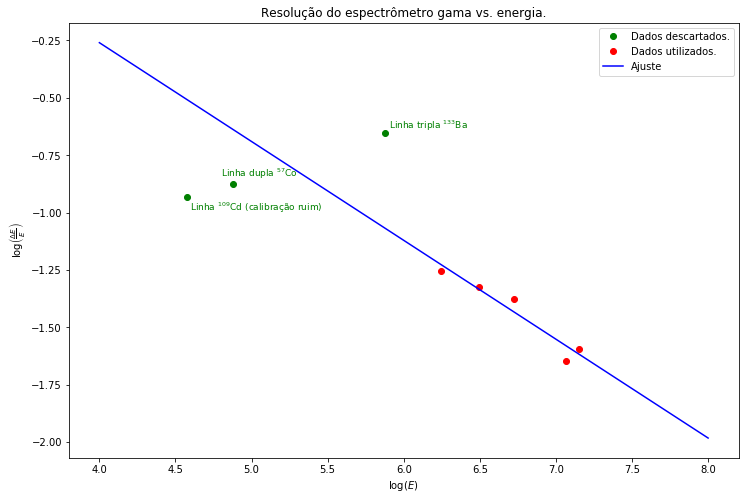

In [4]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

# retirando outliers (linha duplas ba133 e co57 e cd109 - calibração ruim)
delta_E_filt = []
E_filt = []
for en, delta_en in zip(E, delta_E):
    x = np.log(en)
    y = np.log(delta_en/en)
    if (np.abs(en - 357.804) > 1) and (np.abs(en - 131.28) > 1) and (np.abs(en - 96.94) > 1):
        E_filt.append(en)
        delta_E_filt.append(delta_en)
    elif (np.abs(en - 357.804) <= 1):
        ax.plot(x, y, 'go')
        ax.text(x+0.02, y+0.02, "Linha tripla ${}^{133}$Ba", color='green', fontsize=9)
    elif (np.abs(en - 131.28) <= 1):
        ax.plot(x, y, 'go')
        ax.text(x-0.08, y+0.03, "Linha dupla ${}^{57}$Co", color='green', fontsize=9)
    elif (np.abs(en - 96.94) <= 1):
        ax.plot(x, y, 'go', label="Dados descartados.")
        ax.text(x+0.02, y-0.06, "Linha ${}^{109}$Cd (calibração ruim)", color='green', fontsize=9)
E_filt = np.array(E_filt)
delta_E_filt = np.array(delta_E_filt)

# ajuste linear
pvar, pcov = curve_fit(lambda x, a, b: a*x + b, np.log(E_filt), np.log(delta_E_filt/E_filt))
a, b = pvar
da, db = np.sqrt(np.diag(pcov))

xs = np.linspace(4, 8, 2000)
ys = a*xs + b

# plotando
ax.set_title("Resolução do espectrômetro gama vs. energia.")
ax.set_xlabel(r"$\log(E)$")
ax.set_ylabel(r"$\log\left(\frac{\Delta E}{E}\right)$")
ax.plot(np.log(E_filt), np.log(delta_E_filt/E_filt), 'ro', label="Dados utilizados.")
ax.plot(xs, ys, 'b', label='Ajuste')
ax.legend()
fig.savefig("resolucao_loglog.pdf")

print("a: ", a, ", da:", da)
print("b: ", b, ", db:", db)

Note que a reta ajusta relativamente bem os dados obtidos. O valor obtido para o coeficiente angular, $-0.43 \pm 0.07$ está de acordo com o valor teórico esperado ($-0.5$). Três pontos diferem consideravelmente dos demais. Um deles é uma linha múltipla do ${}^{133}$Ba que nosso espectrômetro foi incapaz de separar: na região entre 200 e 400 keV há três linhas espectrais, em $302.8508$, $356.0129$ e $383.8485$ keV. De fato podemos ver em nosso espectro uma assimetria da linha, indicativa de artefatos não resolvidos no espectro.

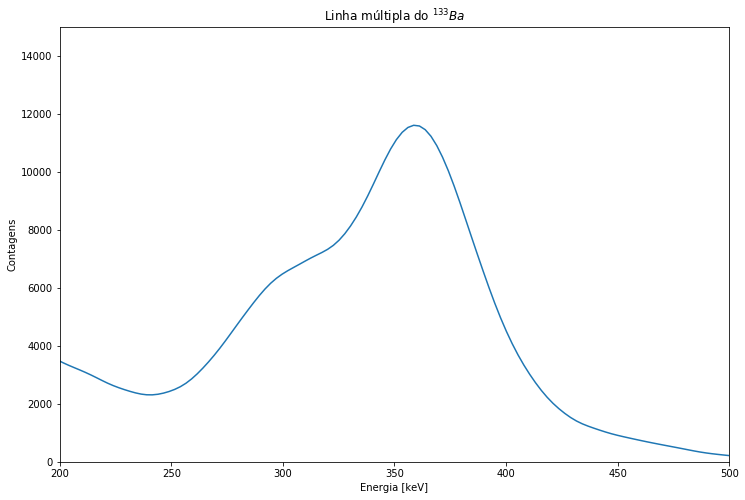

In [5]:
canais, contagens = load_data(arquivos['ba133'])
energias = calibracao(canais, pars_calibracao)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_xlabel("Energia [keV]")
ax.set_ylabel("Contagens")
#ax.set_yscale("log")
ax.set_xlim([200, 500])
ax.set_ylim([0, 15000])
ax.set_title("Linha múltipla do ${}^{133}Ba$")
_ = ax.plot(energias, smooth(contagens, 2))
fig.savefig("linhatripla.pdf")

Outro é uma linha múltipla do ${}^{57}$Co e por fim temos a linha do ${}^{109}$Cd, que já está em uma região onde a calibração é bastante ruim (verificamos anteriormente que a calibração produz desvios da ordem de 10 % nesta região de baixas energias). Estes pontos não foram utilizados para o ajuste linear

a:  38.0765166194 , da: 6.14268859672
b:  0.0110763308732 , db: 0.00817085168399


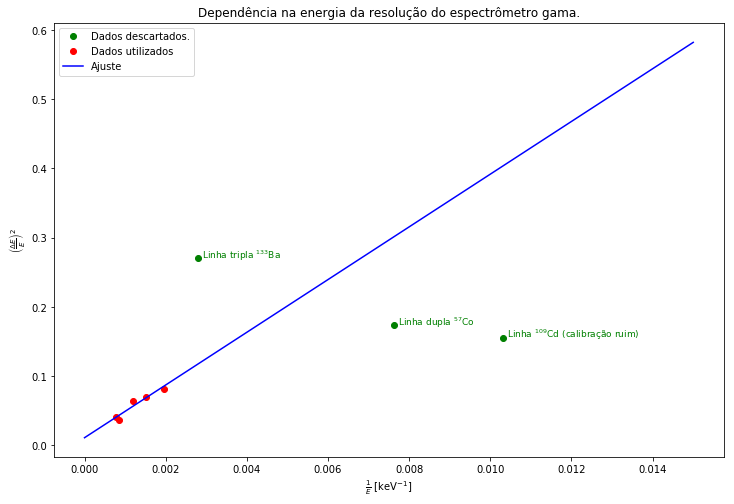

In [6]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

for en, delta_en in zip(E, delta_E):
    x = 1/en
    y = (delta_en/en)**2
    if (np.abs(en - 357.804) > 1) and (np.abs(en - 131.28) > 1) and (np.abs(en - 96.94) > 1):
        pass
    elif (np.abs(en - 357.804) <= 1):
        ax.plot(x, y, 'go')
        ax.text(x+0.0001, y, "Linha tripla ${}^{133}$Ba", color='green', fontsize=9)
    elif (np.abs(en - 131.28) <= 1):
        ax.plot(x, y, 'go')
        ax.text(x+0.0001, y, "Linha dupla ${}^{57}$Co", color='green', fontsize=9)
    elif (np.abs(en - 96.94) <= 1):
        ax.plot(x, y, 'go', label="Dados descartados.")
        ax.text(x+0.0001, y, "Linha ${}^{109}$Cd (calibração ruim)", color='green', fontsize=9)

pvar, pcov = curve_fit(lambda x, a, b: a*x + b, 1/E_filt, (delta_E_filt/E_filt)**2)
a, b = pvar
da, db = np.sqrt(np.diag(pcov))

xs = np.linspace(0.0, 0.015, 2000)
ys = a*xs + b
ax.set_title("Dependência na energia da resolução do espectrômetro gama.")
ax.set_xlabel(r"$\frac{1}{E}$ [keV$^{-1}$]")
ax.set_ylabel(r"$\left(\frac{\Delta E}{E}\right)^2$")
ax.plot(1/E_filt, (delta_E_filt/E_filt)**2, 'ro', label="Dados utilizados")
ax.plot(xs, ys, 'b', label="Ajuste")
ax.legend()
fig.savefig("resolucao_lin.pdf")

print("a: ", a, ", da:", da)
print("b: ", b, ", db:", db)

Novamente vemos que, a menos das linhas descartadas pelos motivos já explicitados, o modelo fornece um bom ajuste aos dados observados.